In [26]:
# ------------------------------
# 1. Load and inspect dataset
# ------------------------------
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np


In [27]:

# Load data
data = pd.read_csv("Combined_dataset.csv")


In [28]:

# ------------------------------
# 2. Create CCME_WQI_Class based on CCME_Values
# ------------------------------
def classify_wqi(value):
    if value >= 90:
        return "Excellent"
    elif value >= 80:
        return "Good"
    elif value >= 65:
        return "Fair"
    elif value >= 45:
        return "Marginal"
    else:
        return "Poor"

data["CCME_WQI_Class"] = data["CCME_Values"].apply(classify_wqi)


In [29]:

# ------------------------------
# 3. Select features and target
# ------------------------------
# Drop non-numeric / irrelevant columns
numeric_features = data.select_dtypes(include=[np.number]).drop(columns=["CCME_Values", "CCME_WQI"], errors="ignore")

X = numeric_features
y = data["CCME_WQI_Class"]

# Encode class labels to integers for logistic regression
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Classes:", label_encoder.classes_)


Classes: ['Excellent' 'Fair' 'Good' 'Marginal' 'Poor']


In [30]:

# ------------------------------
# 4. Split into train / validation / test (70/15/15)
# ------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 1979583
Validation samples: 424197
Testing samples: 424197


In [31]:

# ------------------------------
# 5. Standardize features
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [32]:

# ------------------------------
# 6. Train Logistic Regression models with different regularizations
# ------------------------------
models = {
    "Ridge (L2)": LogisticRegression(
        penalty='l2', solver='saga', multi_class='multinomial', max_iter=5000, random_state=42
    ),
    "Lasso (L1)": LogisticRegression(
        penalty='l1', solver='saga', multi_class='multinomial', max_iter=5000, random_state=42
    ),
    "Elastic Net": LogisticRegression(
        penalty='elasticnet', solver='saga', l1_ratio=0.5, multi_class='multinomial', max_iter=5000, random_state=42
    )
}

val_results = {}
test_results = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")
    model.fit(X_train_scaled, y_train)
    
    # Validation performance
    y_val_pred = model.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_results[name] = val_acc
    print(f"Validation Accuracy ({name}): {val_acc:.4f}")



Training model: Ridge (L2)


c:\Users\Rim\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy (Ridge (L2)): 0.9453

Training model: Lasso (L1)


c:\Users\Rim\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy (Lasso (L1)): 0.9460

Training model: Elastic Net


c:\Users\Rim\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy (Elastic Net): 0.9456


In [ ]:

# ------------------------------
# 7. Evaluate best model on test set
# ------------------------------
best_model_name = max(val_results, key=val_results.get)
best_model = models[best_model_name]
print(f"\n✅ Best model based on validation accuracy: {best_model_name}")

# Evaluate on test data
y_test_pred = best_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_test_pred)

print("\nTest Accuracy:", round(test_acc, 4))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


✅ Best model based on validation accuracy: Lasso (L1)

Test Accuracy: 0.9456

Classification Report:
               precision    recall  f1-score   support

   Excellent       0.99      0.97      0.98    216653
        Fair       0.93      0.91      0.92     47679
        Good       0.90      0.94      0.92     91510
    Marginal       0.91      0.92      0.91     49310
        Poor       0.84      0.81      0.83     19045

    accuracy                           0.95    424197
   macro avg       0.91      0.91      0.91    424197
weighted avg       0.95      0.95      0.95    424197


Confusion Matrix:
 [[210639      0   6014      0      0]
 [   128  43427   3206    918      0]
 [  2823   2233  86454      0      0]
 [     0   1258      0  45196   2856]
 [     0      0      0   3644  15401]]


<Figure size 600x500 with 0 Axes>

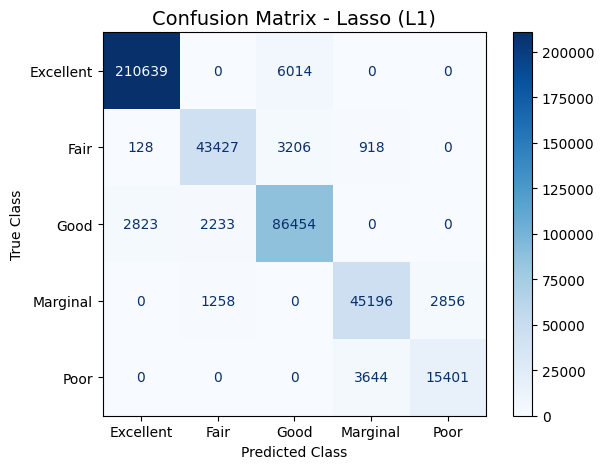

✅ Confusion matrix saved to: Results_Plots\Confusion_Matrix_Lasso (L1).png


In [41]:
# ------------------------------
# 8. Plot and Save Confusion Matrix (Counts)
# ------------------------------
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create folder to save the plot
save_dir = "Results_Plots"
os.makedirs(save_dir, exist_ok=True)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", colorbar=True)
plt.title(f"Confusion Matrix - {best_model_name}", fontsize=14)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()

# Save the plot
save_path = os.path.join(save_dir, f"Confusion_Matrix_{best_model_name}.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

print(f"✅ Confusion matrix saved to: {save_path}")


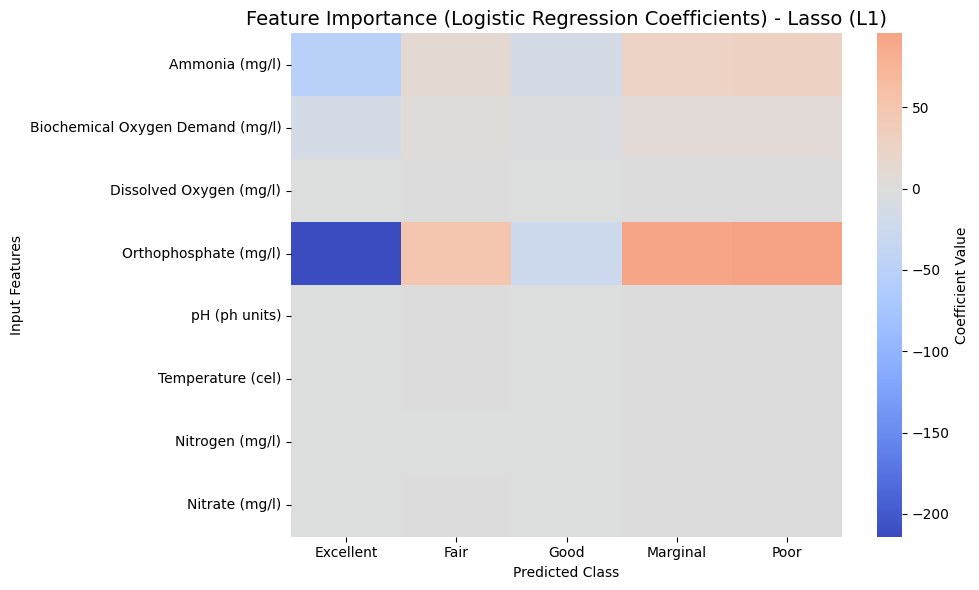


Top 3 most influential features per class:

Excellent: ['Orthophosphate (mg/l)', 'Ammonia (mg/l)', 'Biochemical Oxygen Demand (mg/l)']
Fair: ['Orthophosphate (mg/l)', 'Ammonia (mg/l)', 'Biochemical Oxygen Demand (mg/l)']
Good: ['Orthophosphate (mg/l)', 'Ammonia (mg/l)', 'Biochemical Oxygen Demand (mg/l)']
Marginal: ['Orthophosphate (mg/l)', 'Ammonia (mg/l)', 'Biochemical Oxygen Demand (mg/l)']
Poor: ['Orthophosphate (mg/l)', 'Ammonia (mg/l)', 'Biochemical Oxygen Demand (mg/l)']


In [34]:
# ------------------------------
# 9. Feature Importance Visualization
# ------------------------------
import numpy as np

# Extract coefficients from the best model
coef = best_model.coef_

# Convert to DataFrame for visualization
feature_importance_df = pd.DataFrame(
    coef.T,
    index=X.columns,
    columns=label_encoder.classes_
)

# Plot heatmap of coefficients
plt.figure(figsize=(10, 6))
sns.heatmap(
    feature_importance_df,
    cmap="coolwarm",
    center=0,
    annot=False,
    cbar_kws={'label': 'Coefficient Value'}
)
plt.title(f"Feature Importance (Logistic Regression Coefficients) - {best_model_name}", fontsize=14)
plt.xlabel("Predicted Class")
plt.ylabel("Input Features")
plt.tight_layout()
plt.show()

# ------------------------------
# Optional: Top features per class (text summary)
# ------------------------------
print("\nTop 3 most influential features per class:\n")
for i, class_name in enumerate(label_encoder.classes_):
    top_features = (
        feature_importance_df[class_name]
        .abs()
        .sort_values(ascending=False)
        .head(3)
        .index.tolist()
    )
    print(f"{class_name}: {top_features}")


What this does

Extracts model coefficients (best_model.coef_) → shape is [n_classes, n_features].

Creates a heatmap showing which features contribute most (red = positive influence, blue = negative).

Lists the top 3 most influential features for each class in text form below the plot.

🧠 How to interpret the heatmap

Each column = one WQI class (Excellent, Good, Fair, Marginal, Poor).

Each row = one input feature (like pH, Ammonia, etc.).

Red cells → increase probability of that class.

Blue cells → decrease probability of that class.

The darker the color, the stronger the effect.

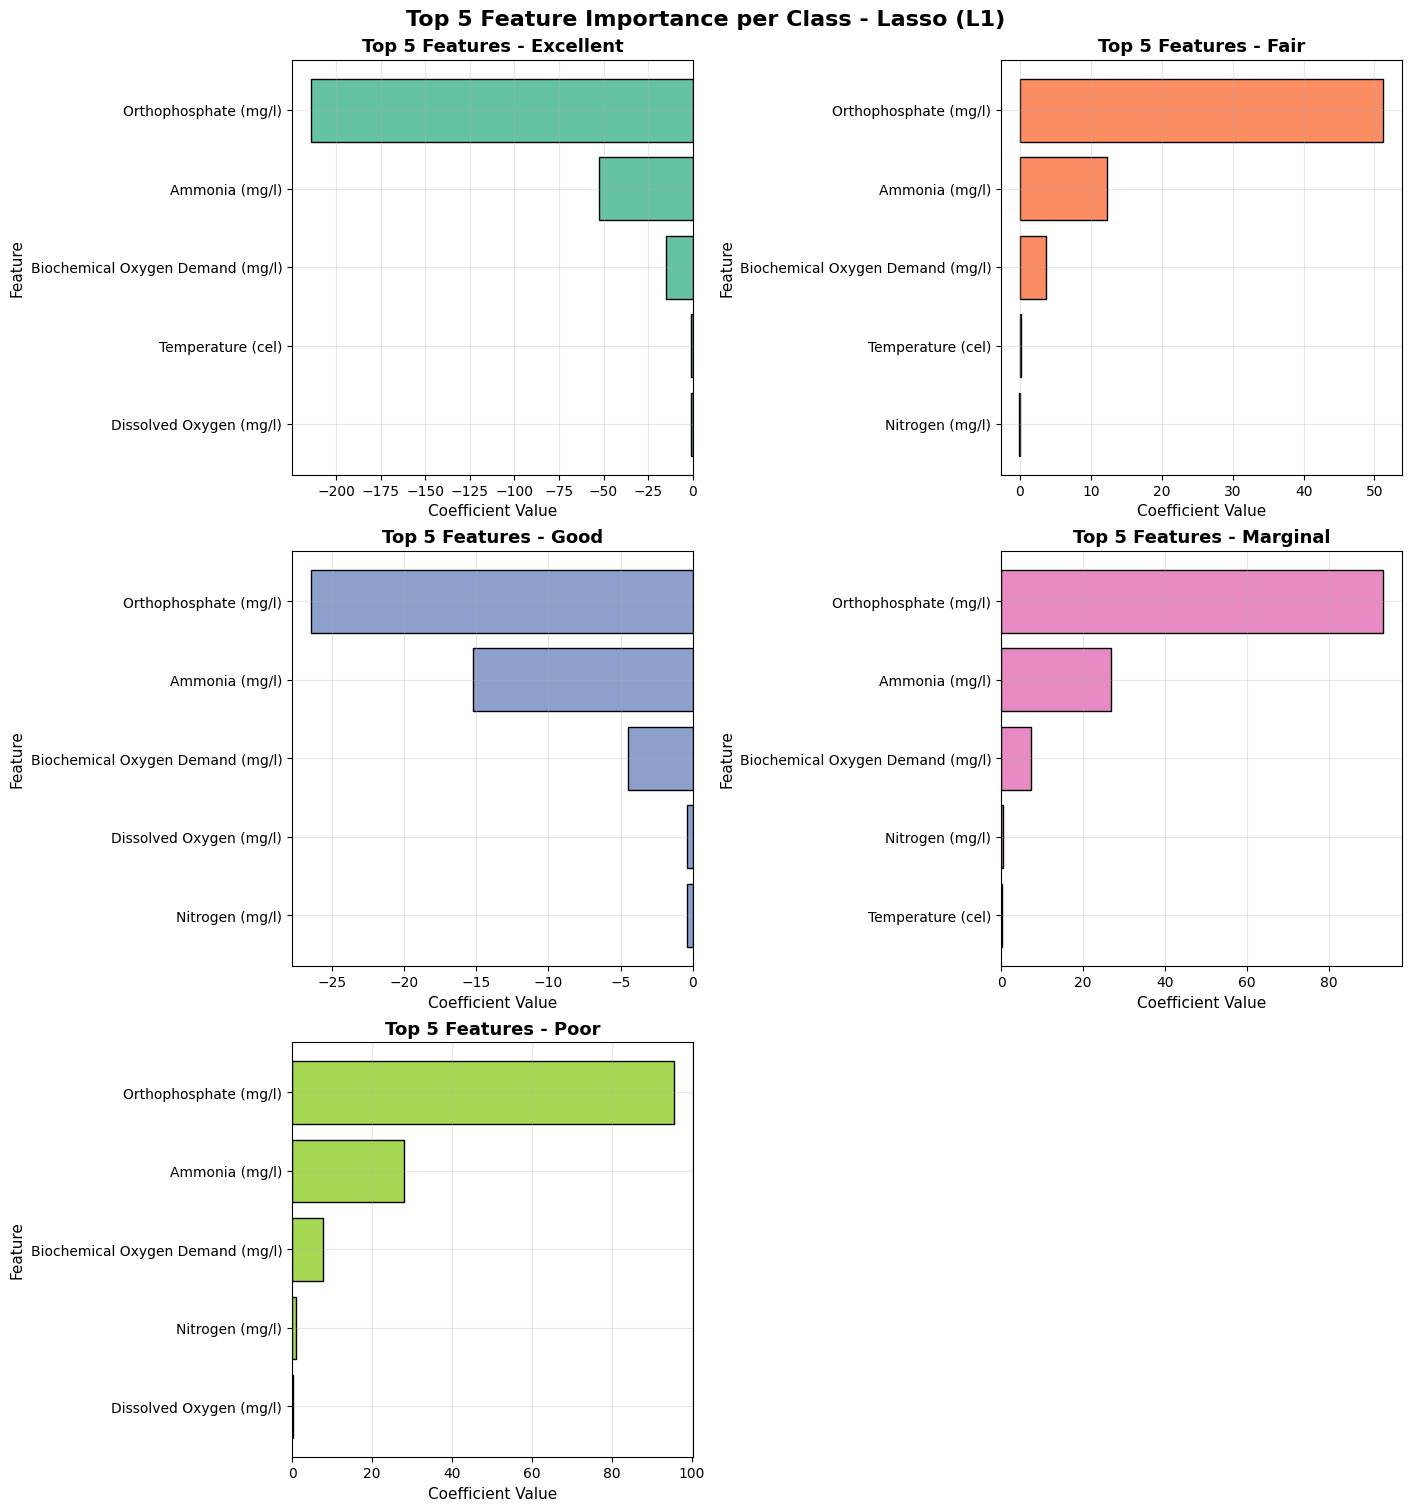

✅ Saved feature importance bar plots to: Results_Plots\Top5_Features_Per_Class_Lasso (L1).png


In [42]:
# ------------------------------
# 10. Top 5 Feature Bar Plots per Class
# ------------------------------
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create folder to save plots
save_dir = "Results_Plots"
os.makedirs(save_dir, exist_ok=True)
# ------------------------------
# Top 5 Features per Class (Bar Plots)
# ------------------------------
num_classes = len(label_encoder.classes_)
fig, axes = plt.subplots(
    nrows=int(np.ceil(num_classes / 2)),
    ncols=2,
    figsize=(14, 5 * int(np.ceil(num_classes / 2))),
    constrained_layout=True
)
axes = axes.flatten()

# Color palette
palette = sns.color_palette("Set2", num_classes)

for i, class_name in enumerate(label_encoder.classes_):
    top_features = (
        feature_importance_df[class_name]
        .sort_values(key=lambda x: np.abs(x), ascending=False)
        .head(5)
    )
    color = palette[i % len(palette)]
    axes[i].barh(top_features.index[::-1], top_features.values[::-1], color=color, edgecolor='black')
    axes[i].set_title(f"Top 5 Features - {class_name}", fontsize=13, weight='bold')
    axes[i].set_xlabel("Coefficient Value", fontsize=11)
    axes[i].set_ylabel("Feature", fontsize=11)
    axes[i].grid(alpha=0.3)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle(f"Top 5 Feature Importance per Class - {best_model_name}", fontsize=16, weight='bold')
plt.show()

# Save bar plot figure
bar_plot_path = os.path.join(save_dir, f"Top5_Features_Per_Class_{best_model_name}.png")
fig.savefig(bar_plot_path, dpi=300, bbox_inches='tight')

print(f"✅ Saved feature importance bar plots to: {bar_plot_path}")
